In [1]:
### General imports ###
import os
from glob import glob
import pickle
import itertools
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

### Graph imports ###
import matplotlib.pyplot as plt
from PIL import Image

### Audio import ###
import librosa
import IPython
from IPython.display import Audio

In [2]:
label_dict_ravdess = {'02': 'NEU', '03':'HAP', '04':'SAD', '05':'ANG', '06':'FEA', '07':'DIS', '08':'SUR'}

# Set audio files labels
def set_label_ravdess(audio_file, gender_differentiation):
    label = label_dict_ravdess.get(audio_file[6:-16])
    if gender_differentiation == True:
        if int(audio_file[18:-4])%2 == 0: # Female
            label = 'f_' + label
        if int(audio_file[18:-4])%2 == 1: # Male
            label = 'm_' + label
    return label

In [4]:
print("Import Data: START")

# Audio file path and names
file_path = './DATAS/RAVDESS/'
file_names = os.listdir(file_path)

# Initialize features and labels list
signal = []
labels = []

# Sample rate (16.0 kHz)
sample_rate = 16000     

# Max pad lenght (3.0 sec)
max_pad_len = 49100

# Compute spectogram for all audio file
for audio_index, audio_file in enumerate(file_names):
    
    if audio_file[6:-16] in list(label_dict_ravdess.keys()):
        
        # Read audio file
        y, sr = librosa.core.load(file_path + audio_file, sr=sample_rate, offset=0.5)
        
        # Z-normalization
        y = zscore(y)
        
        # Padding or truncated signal 
        if len(y) < max_pad_len:    
            y_padded = np.zeros(max_pad_len)
            y_padded[:len(y)] = y
            y = y_padded
        elif len(y) > max_pad_len:
            y = np.asarray(y[:max_pad_len])
        
        # Add to signal list
        signal.append(y)
        
        # Set label
        labels.append(set_label_ravdess(audio_file, False))

        # Print running...
        if (audio_index % 100 == 0):
            print("Import Data: RUNNING ... {} files".format(audio_index))
        
# Cast labels to array
labels = np.asarray(labels).ravel()

# Stop feature extraction
print("Import Data: END \n")
print("Number of audio files imported: {}".format(labels.shape[0]))

Import Data: START
Import Data: RUNNING ... 100 files
Import Data: RUNNING ... 200 files
Import Data: RUNNING ... 300 files
Import Data: RUNNING ... 400 files
Import Data: RUNNING ... 500 files
Import Data: RUNNING ... 600 files
Import Data: RUNNING ... 700 files
Import Data: RUNNING ... 800 files
Import Data: RUNNING ... 900 files
Import Data: RUNNING ... 1000 files
Import Data: RUNNING ... 1100 files
Import Data: RUNNING ... 1200 files
Import Data: RUNNING ... 1300 files
Import Data: RUNNING ... 1400 files
Import Data: END 

Number of audio files imported: 1344


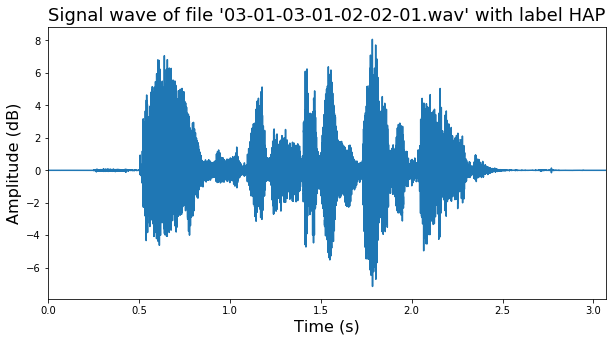

Audio file '03-01-03-01-02-02-01.wav':


In [5]:
# Select one random audio file
random_idx = np.random.randint(len(labels))
random_label = labels[random_idx]
random_signal = signal[random_idx]
random_filename = file_names[random_idx]

# Plot signal wave
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(random_signal))/float(sample_rate), random_signal)
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title("Signal wave of file '{}' with label {}".format(random_filename, random_label), fontsize=18)
plt.show()

# Play audio file
print("Audio file '{}':".format(random_filename))
Audio(random_signal, rate=sample_rate)

In [6]:
# Number of augmented data
nb_augmented = 2

# Function to add noise to a signals with a desired Signal Noise ratio (SNR)
def noisy_signal(signal, snr_low=15, snr_high=30, nb_augmented=2):
    
    # Signal length
    signal_len = len(signal)

    # Generate White noise
    noise = np.random.normal(size=(nb_augmented, signal_len))
    
    # Compute signal and noise power
    s_power = np.sum((signal / (2.0 ** 15)) ** 2) / signal_len
    n_power = np.sum((noise / (2.0 ** 15)) ** 2, axis=1) / signal_len
    
    # Random SNR: Uniform [15, 30]
    snr = np.random.randint(snr_low, snr_high)
    
    # Compute K coeff for each noise
    K = np.sqrt((s_power / n_power) * 10 ** (- snr / 10))
    K = np.ones((signal_len, nb_augmented)) * K
    
    # Generate noisy signal
    return signal + K.T * noise

In [7]:
# Generate noisy signals from signal list
print("Data Augmentation: START")
augmented_signal = list(map(noisy_signal, signal))
print("Data Augmentation: END!")

Data Augmentation: START
Data Augmentation: END!


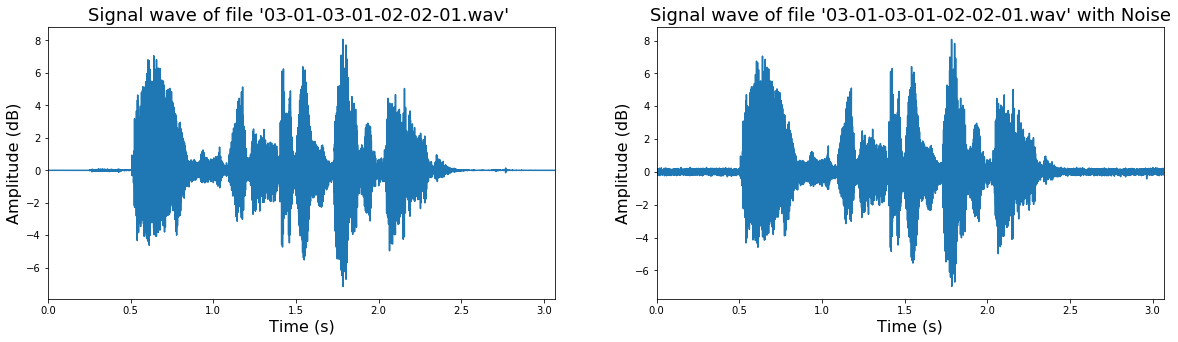

Audio file '03-01-03-01-02-02-01.wav':


Audio file '03-01-03-01-02-02-01.wav' with noise:


In [8]:
# Plot signal wave
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(np.arange(len(random_signal))/float(sample_rate), random_signal)
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title("Signal wave of file '{}' ".format(random_filename), fontsize=18)

# Plot signal wave with noise
plt.subplot(1,2,2)
plt.plot(np.arange(len(random_signal))/float(sample_rate), augmented_signal[random_idx][0])
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title("Signal wave of file '{}' with Noise".format(random_filename), fontsize=18)
plt.show()

# Play audio file
print("Audio file '{}':".format(random_filename))
IPython.display.display(Audio(random_signal, rate=sample_rate))

# Play same audio file with noise
print("Audio file '{}' with noise:".format(random_filename))
IPython.display.display(Audio(augmented_signal[random_idx][0], rate=sample_rate))

In [9]:
def mel_spectrogram(y, sr=16000, n_fft=512, win_length=256, hop_length=128, window='hamming', n_mels=128, fmax=4000):
    
    # Compute spectogram
    mel_spect = np.abs(librosa.stft(y, n_fft=n_fft, window=window, win_length=win_length, hop_length=hop_length)) ** 2
    
    # Compute mel spectrogram
    mel_spect = librosa.feature.melspectrogram(S=mel_spect, sr=sr, n_mels=n_mels, fmax=fmax)
    
    # Compute log-mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    
    return mel_spect

In [10]:
# Start feature extraction
print("Feature extraction: START")

# Compute spectogram for all audio file
mel_spect = np.asarray(list(map(mel_spectrogram, signal)))
augmented_mel_spect = [np.asarray(list(map(mel_spectrogram, augmented_signal[i]))) for i in range(len(augmented_signal))]

# Stop feature extraction
print("Feature extraction: END!")

Feature extraction: START
Feature extraction: END!


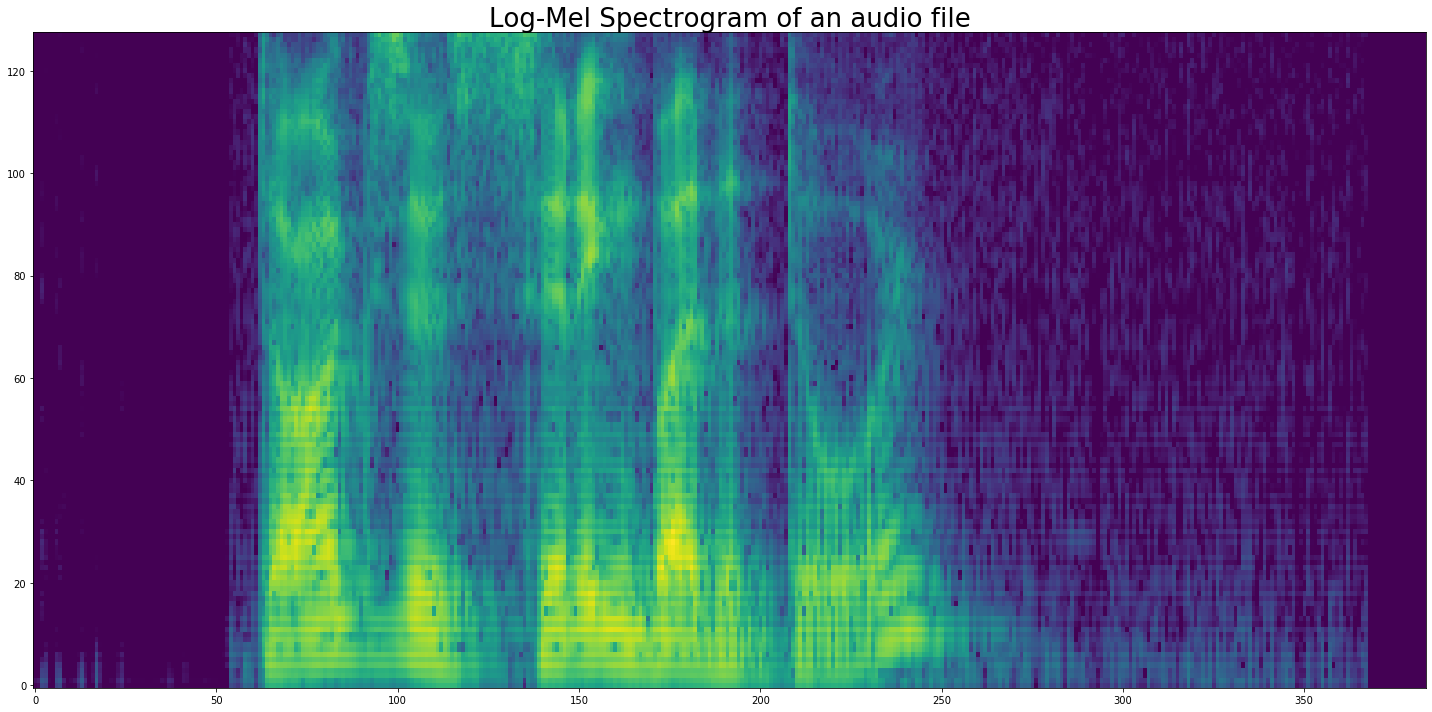

In [11]:
# Plot one random Spectogram 
plt.figure(figsize=(20, 10))
plt.imshow(mel_spect[np.random.randint(len(mel_spect))], origin='lower', aspect='auto', cmap='viridis')
plt.title('Log-Mel Spectrogram of an audio file', fontsize=26)
plt.tight_layout()
plt.show()

In [12]:
# Build Train and test dataset
MEL_SPECT_train, MEL_SPECT_test, AUG_MEL_SPECT_train, AUG_MEL_SPECT_test, label_train, label_test = train_test_split(mel_spect, augmented_mel_spect, labels, test_size=0.2)

# Build augmented labels and train
aug_label_train = np.asarray(list(itertools.chain.from_iterable([[label] * nb_augmented for label in label_train])))
AUG_MEL_SPECT_train = np.asarray(list(itertools.chain.from_iterable(AUG_MEL_SPECT_train)))

# Concatenate original and augmented
X_train = np.concatenate((MEL_SPECT_train, AUG_MEL_SPECT_train))
y_train = np.concatenate((label_train, aug_label_train))

# Build test set
X_test = MEL_SPECT_test
y_test = label_test

# Delete
del MEL_SPECT_train, AUG_MEL_SPECT_train, label_train, aug_label_train, AUG_MEL_SPECT_test, MEL_SPECT_test, label_test
del mel_spect, augmented_mel_spect, labels

In [13]:
# Time distributed parameters
win_ts = 128
hop_ts = 64

# Split spectrogram into frames
def frame(x, win_step=128, win_size=64):
    nb_frames = 1 + int((x.shape[2] - win_size) / win_step)
    frames = np.zeros((x.shape[0], nb_frames, x.shape[1], win_size)).astype(np.float32)
    for t in range(nb_frames):
        frames[:,t,:,:] = np.copy(x[:,:,(t * win_step):(t * win_step + win_size)]).astype(np.float32)
    return frames

# Frame for TimeDistributed model
X_train = frame(X_train, hop_ts, win_ts)
X_test = frame(X_test, hop_ts, win_ts)

In [15]:
# Save Train and test set
pickle.dump(X_train.astype(np.float16), open('./DATAS/Pickle/RAVDESS/DIS/[RAVDESS][MEL_SPECT][X_train].p', 'wb'))
pickle.dump(y_train, open('./DATAS/Pickle/RAVDESS/DIS/[RAVDESS][MEL_SPECT][y_train].p', 'wb'))
pickle.dump(X_test.astype(np.float16), open('./DATAS/Pickle/RAVDESS/DIS/[RAVDESS][MEL_SPECT][X_test].p', 'wb'))
pickle.dump(y_test, open('./DATAS/Pickle/RAVDESS/DIS/[RAVDESS][MEL_SPECT][y_test].p', 'wb'))

In [7]:
### Time Distributed ConvNet imports ###
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

### Plot imports ###
from IPython.display import Image

### Warning ###
import warnings
warnings.filterwarnings('ignore')

In [3]:
# RAVDESS mel-Spectrogram
X_train = pickle.load(open('./DATAS/Pickle/RAVDESS/DIS/[RAVDESS][MEL_SPECT][X_train].p', 'rb'))
y_train = pickle.load(open('./DATAS/Pickle/RAVDESS/DIS/[RAVDESS][MEL_SPECT][y_train].p', 'rb'))
y_test = pickle.load(open('./DATAS/Pickle/RAVDESS/DIS/[RAVDESS][MEL_SPECT][y_test].p', 'rb'))
X_test = pickle.load(open('./DATAS/Pickle/RAVDESS/DIS/[RAVDESS][MEL_SPECT][X_test].p', 'rb'))

In [4]:
# Encode Label from categorical to numerical
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(np.ravel(y_train)))
y_test = to_categorical(lb.transform(np.ravel(y_test)))

In [5]:
# Reshape for convolution
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , X_train.shape[2], X_train.shape[3], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , X_test.shape[2], X_test.shape[3], 1)

In [9]:
K.clear_session()

# Define two sets of inputs: MFCC and FBANK
input_y = Input(shape=X_train.shape[1:], name='Input_MELSPECT')

## First LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_1_MELSPECT')(input_y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_1_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_1_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), name='MaxPool_1_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_1_MELSPECT')(y)     

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_2_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_2_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_2_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_2_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_2_MELSPECT')(y)

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_3_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_3_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_3_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_3_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_3_MELSPECT')(y)

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_4_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_4_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_4_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_4_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_4_MELSPECT')(y)  

## Flat
y = TimeDistributed(Flatten(), name='Flat_MELSPECT')(y)                      
                               
# Apply 2 LSTM layer and one FC
y = LSTM(256, return_sequences=False, dropout=0.2, name='LSTM_1')(y)
y = Dense(y_train.shape[1], activation='softmax', name='FC')(y)

# Build final model
model = Model(inputs=input_y, outputs=y)

In [12]:
# Compile model
model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint('drive/My Drive/SpeechEmotionRecognition/[CNN-LSTM]Model.hdf5', save_best_only=True, monitor='val_acc', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='max')

# Fit model
history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save])

Train on 3225 samples, validate on 269 samples
Epoch 1/100
3225/3225 [==============================] - 63s 19ms/sample - loss: 1.8738 - accuracy: 0.2220 - val_loss: 1.7482 - val_accuracy: 0.2937
Epoch 2/100
3225/3225 [==============================] - 49s 15ms/sample - loss: 1.6893 - accuracy: 0.3132 - val_loss: 1.7053 - val_accuracy: 0.2974
Epoch 3/100
3225/3225 [==============================] - 49s 15ms/sample - loss: 1.6044 - accuracy: 0.3606 - val_loss: 1.5086 - val_accuracy: 0.4052
Epoch 4/100
3225/3225 [==============================] - 49s 15ms/sample - loss: 1.5570 - accuracy: 0.3836 - val_loss: 1.4598 - val_accuracy: 0.4126
Epoch 5/100
3225/3225 [==============================] - 49s 15ms/sample - loss: 1.4868 - accuracy: 0.4146 - val_loss: 1.5517 - val_accuracy: 0.4052
Epoch 6/100
3225/3225 [==============================] - 49s 15ms/sample - loss: 1.4177 - accuracy: 0.4496 - val_loss: 1.2559 - val_accuracy: 0.4944
Epoch 7/100
3225/3225 [==============================] - 49

Epoch 27/100
3225/3225 [==============================] - 49s 15ms/sample - loss: 0.6663 - accuracy: 0.7479 - val_loss: 0.9856 - val_accuracy: 0.6877
Epoch 28/100
3225/3225 [==============================] - 50s 16ms/sample - loss: 0.6165 - accuracy: 0.7640 - val_loss: 1.2649 - val_accuracy: 0.6022
Epoch 29/100
3225/3225 [==============================] - 50s 16ms/sample - loss: 0.5858 - accuracy: 0.7839 - val_loss: 1.4020 - val_accuracy: 0.5576
Epoch 30/100
3225/3225 [==============================] - 50s 16ms/sample - loss: 0.5776 - accuracy: 0.7839 - val_loss: 0.9890 - val_accuracy: 0.7063
Epoch 31/100
3225/3225 [==============================] - 50s 15ms/sample - loss: 0.5303 - accuracy: 0.8043 - val_loss: 0.9395 - val_accuracy: 0.6729
Epoch 32/100
3225/3225 [==============================] - 50s 15ms/sample - loss: 0.5343 - accuracy: 0.8006 - val_loss: 1.1771 - val_accuracy: 0.5948
Epoch 33/100
3225/3225 [==============================] - 46s 14ms/sample - loss: 0.4958 - accuracy:

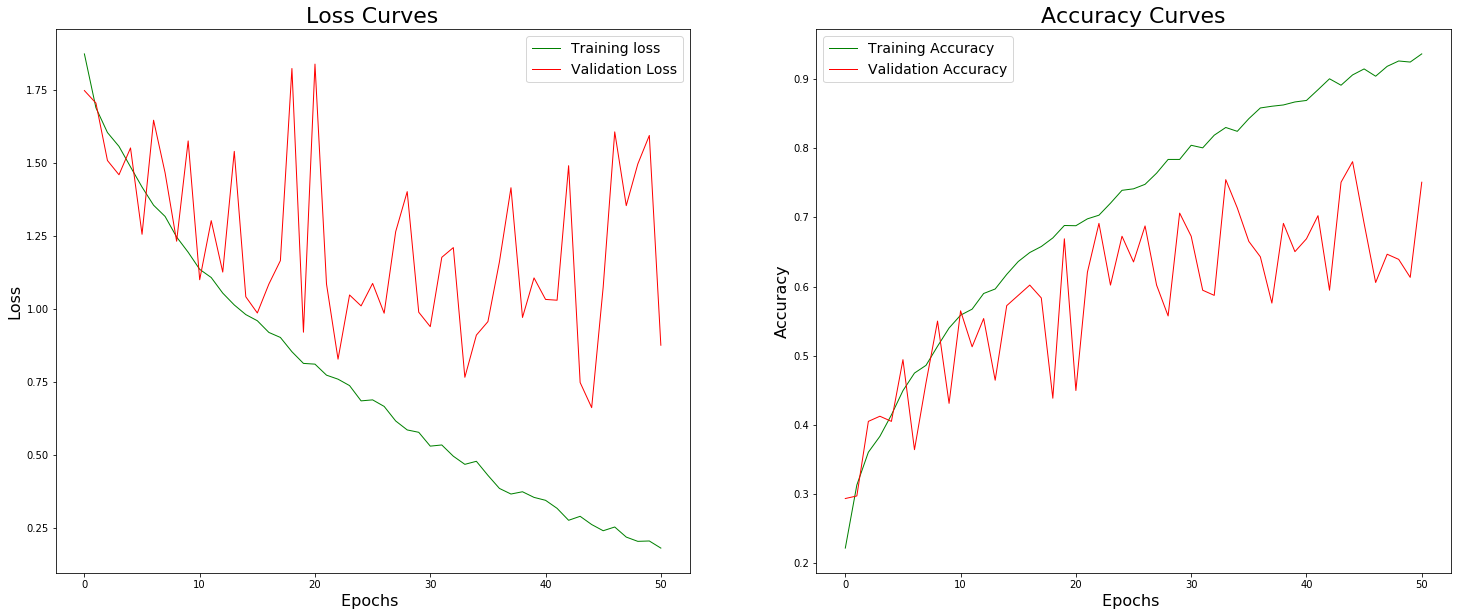

In [14]:
# Loss Curves
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'],'-g',linewidth=1.0)
plt.plot(history.history['val_loss'],'r',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=22)
 
# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'],'-g',linewidth=1.0)
plt.plot(history.history['val_accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=22)
plt.show()

In [15]:
model.save('./Models/[CNN-LSTM]Model.h5')
model.save_weights('./Models/[CNN-LSTM]Weights.h5')